In [110]:

import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text
from datetime import datetime

In [111]:
# Print the modified DataFrame
pd.set_option('display.max_columns', None)

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#F2D2BD'
line_color= '#000000'
col1= '#000000'
col2 = '#ffffff'

In [112]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

# Put the match html file path here
match_html_path = './Paris Saint-Germain 1-3 Nice - Ligue 1 2024:2025 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

df.to_csv('EventData.csv')
df = pd.read_csv('EventData.csv')
dfp.to_csv('PlayerData.csv')
dfp = pd.read_csv('PlayerData.csv')

# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT = dfxT[~dfxT['qualifiers'].str.contains('Corner') & ~dfxT['qualifiers'].str.contains('ThrowIn')]
dfxT = dfxT[(dfxT['type']=='Pass') & (dfxT['outcomeType']=='Successful')]

xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='Unnamed: 0', how='left')
# Creating another column for teamName
df['teamName'] = df['teamId'].map(teams_dict)

# Reshaping the data from 100x100 to 105x68
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

columns_to_drop = ['Unnamed: 0','height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
                   'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)
df = df.merge(dfp, on='playerId', how='left')

# Calculating passing distance, to find out progressive pass
df['pro'] = np.where((df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['x'] > 42),
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['name'].apply(get_short_name)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/3395768038.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/3395768038.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)


In [113]:
# Assigning values into some variables which will be used later
hteamID = list(teams_dict.keys())[0]
ateamID = list(teams_dict.keys())[1]
hteamName= teams_dict[hteamID]
ateamName= teams_dict[ateamID]

hcol= col1
acol= col2
# hcol= col2
# acol= col1

homedf = df[(df['teamId']==hteamID)]
awaydf = df[(df['teamId']==ateamID)]
hxT = homedf['xT'].sum().round(2)
axT = awaydf['xT'].sum().round(2)

hgoal_count = len(homedf[(homedf['teamId']==hteamID) & (homedf['type']=='Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = len(awaydf[(awaydf['teamId']==ateamID) & (awaydf['type']=='Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))])
hgoal_count = hgoal_count + len(awaydf[(awaydf['teamId']==ateamID) & (awaydf['type']=='Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = agoal_count + len(homedf[(homedf['teamId']==hteamID) & (homedf['type']=='Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))])

# These xG and xGOT values I copy from the fotmob website and put here manually, as I don't want to use those complicated ways of web scraping
hxg   = 2.78
axg   = 0.96
hxgot = 3.11
axgot = 0.86
file_header = f'{hteamName}_vs_{ateamName}'

league = 'Ligue 1, 2024-25'
gw = 31
date = '25 April, 2025'

In [114]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df["receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

passes_df = get_passes_df(events_dict)
path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def get_passes_between_df(team_id, passes_df, players_df):
    passes_df = passes_df[passes_df["teamId"] == team_id]
    df = pd.DataFrame(events_dict)
    dfteam = df[df['teamId'] == team_id]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, team_id, flipped=False):
    MAX_LINE_WIDTH = 15
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', goal_type='box', goal_alpha=.5, corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)

    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=bg_color, edgecolor=line_color, linewidth=2, alpha=1, ax=ax)
      else:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='s', color=bg_color, edgecolor=line_color, linewidth=2, alpha=0.75, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=18, ax=ax)

    # Plotting a vertical line to show the median vertical position of all passes
    avgph = round(average_locs_and_count_df['pass_avg_x'].median(), 2)
    avgph_show = round(avgph * 1.05, 2)
    ax.axvline(x=avgph, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    if team_id == away_team_id:
      # inverting the pitch for away team
      ax.invert_xaxis()
      ax.invert_yaxis()
      ax.text(avgph+1, 105, f"{avgph_show}m", fontsize=15, color=line_color, ha='right')
    else:
      ax.text(avgph+1, -5, f"{avgph_show}m", fontsize=15, color=line_color, ha='left')

    # Headlines and other texts
    if team_id == home_team_id:
      ax.text(2,98, "circle = starter\nbox = sub", color=hcol, size=12, ha='left', va='top')
      ax.text(-2,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.set_title(f"Home team Passing Network", color=line_color, size=30, fontweight='bold', path_effects=path_eff)
      ax.text(0, 137, '', color=line_color, fontsize=25, ha='left', va='center')
    else:
      ax.text(2,2, "circle = starter\nbox = sub", color=acol, size=12, ha='right', va='top')
      ax.text(-2,105, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.set_title(f"Away team Passing Network", color=line_color, size=30, fontweight='bold', path_effects=path_eff)
      ax.text(0, -37, 'Created by: @HazanSerifli', color=line_color, fontsize=25, ha='right', va='center')

    return pitch

In [115]:
def get_defensive_action_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # filter only defensive actions
    defensive_actions_ids = df.index[(df['eventType'] == 'Aerial') & (df['x'] <= 80) |
                                     (df['eventType'] == 'BallRecovery') |
                                     (df['eventType'] == 'BlockedPass') |
                                     (df['eventType'] == 'Challenge') |
                                     (df['eventType'] == 'Clearance') |
                                     (df['eventType'] == 'Error') |
                                     (df['eventType'] == 'Foul') |
                                     (df['eventType'] == 'Interception') |
                                     (df['eventType'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["id", "x", "y", "teamId", "playerId", "eventType", "outcomeType"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def get_da_count_df(team_id, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamId"] == team_id]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(hteamID, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(ateamID, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position'] != 'GK']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position'] != 'GK']

def defensive_block(ax, average_locs_and_count_df, title, team_id, col):
  defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamId"] == team_id]
  pitch = Pitch(pitch_type='opta', pitch_color=bg_color, line_color=line_color,  linewidth=2, line_zorder=2, corner_arcs=True, goal_type='box', goal_alpha=.5)
  pitch.draw(ax=ax)
  ax.set_facecolor(bg_color)

  # using variable marker size for each player according to their defensive engagements
  MAX_MARKER_SIZE = 3500
  average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
  # plotting the heatmap of the team defensive actions
  color = np.array(to_rgba(col))
  flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                  [bg_color, col], N=500)
  kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

  # using different node marker for starting and substitute players
  for index, row in average_locs_and_count_df.iterrows():
    if row['isFirstEleven'] == True:
      da_nodes = pitch.scatter(row['x'], row['y'],
                               s=row['marker_size']+100, marker='o',
                               color=bg_color, edgecolor=line_color, linewidth=1, alpha=1, zorder=3, ax=ax)
    else:
      da_nodes = pitch.scatter(row['x'], row['y'],
                               s=row['marker_size']+100, marker='s',
                               color=bg_color, edgecolor=line_color, linewidth=1, alpha=1, zorder=3, ax=ax)
  # plotting very tiny scatterings for the defensive actions
  da_scatter = pitch.scatter(defensive_actions_team_df.x, defensive_actions_team_df.y,
                               s=10, marker='x',
                               color='yellow', alpha=0.2, ax=ax)

  # Plotting the shirt no. of each player
  for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.x, row.y), c=line_color, ha='center', va='center', size=(14), ax=ax)

  # Plotting a vertical line to show the median vertical position of all defensive actions, which is called Defensive Actions Height
  dah = average_locs_and_count_df['x'].mean().round(2)
  dah_show = (dah*1.05).round(2)
  ax.axvline(x=dah, color='gray', linestyle='--', alpha=0.75, linewidth=2)
  if team_id == ateamID:
    # inverting the axis for away team
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.text(dah+1, 105, f"{dah_show}m", fontsize=15, color=line_color, ha='right', va='center')
  else:
    ax.text(dah+1, -5, f"{dah_show}m", fontsize=15, color=line_color, ha='left', va='center')

  # Headlines and other texts
  if team_id == home_team_id:
      ax.text(2,98, "circle = starter\nbox = sub", color='gray', size=12, ha='left', va='top')
      ax.text(-2,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.set_title(f"Home team Defensive Block", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
  else:
      ax.text(2,2, "circle = starter\nbox = sub", color='gray', size=12, ha='right', va='top')
      ax.text(-2,105, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.set_title(f"Away team Defensive Block", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)

  return pitch

In [116]:
# filtering the passes without corners
mask = df['teamId'] == ateamID
dfapp = df[mask]
dfapp = dfapp.loc[dfapp['type'] == "Pass"]
dfapp = dfapp[~dfapp['qualifiers'].str.contains('Corner')]

mask = df['teamId'] == hteamID
dfhpp = df[mask]
dfhpp = dfhpp.loc[dfhpp['type'] == "Pass"]
dfhpp = dfhpp[~dfhpp['qualifiers'].str.contains('Corner')]

def draw_progressive_pass_map(ax, df, title, col):
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)

    if title == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    # filtering the progressive passes only
    dfpro = df[df['pro'] >= 9.144]
    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=45.33])
    mid_pro = len(dfpro[(dfpro['y']>=22.67) & (dfpro['y']<45.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<22.67)])
    left_percentage = int((left_pro/pro_count)*100)
    mid_percentage = int((mid_pro/pro_count)*100)
    right_percentage = int((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    if col == hcol:
      ax.text(27, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center')
      ax.text(27, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center')
      ax.text(27, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center')
    else:
      ax.text(27, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center')
      ax.text(27, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center')
      ax.text(27, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center')

    # plotting the passes
    pro_pass = pitch.lines(dfpro.x, dfpro.y, dfpro.endX, dfpro.endY, lw=3.5, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpro.endX, dfpro.endY, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)

    counttext = f"{pro_count} Progressive Passes"

    # Heading and other texts
    if col == hcol:
      ax.text(0,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.set_title(f"Home team:{counttext}", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(0,73, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.set_title(f"Away team:{counttext}", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
     

In [117]:
# filtering the passes without corners
dfhp = df.loc[df['teamId'] == hteamID]
dfhp = dfhp.loc[dfhp['type'] == "Pass"]
dfhp = dfhp.loc[dfhp['outcomeType'] == "Successful"]
dfhp = dfhp[~dfhp['qualifiers'].str.contains('Corner')]

dfap = df.loc[df['teamId'] == ateamID]
dfap = dfap.loc[dfap['type'] == "Pass"]
dfap = dfap.loc[dfap['outcomeType'] == "Successful"]
dfap = dfap[~dfap['qualifiers'].str.contains('Corner')]

def draw_pass_map(ax, df, title, col):
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color,  linewidth=2,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.set_facecolor(bg_color)
    if title == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    # setting the count varibale
    z14 = 0
    hs = 0

    # iterating ecah pass and according to the conditions plotting only zone14 and half spaces passes
    for index, row in df.iterrows():
        if row['endX'] >= 70 and row['endX'] <= 88.54 and row['endY'] >= 22.66 and row['endY'] <= 45.32:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.75, mutation_scale=20, color='orange', linewidth=1.5)
            ax.add_patch(arrow)
            z14 += 1
        if row['endX'] >= 70 and row['endY'] >= 11.33 and row['endY'] <= 22.66:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.75, mutation_scale=20, color=col, linewidth=1.5)
            ax.add_patch(arrow)
            hs += 1
        if row['endX'] >= 70 and row['endY'] >= 45.32 and row['endY'] <= 56.95:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.75, mutation_scale=20, color=col, linewidth=1.5)
            ax.add_patch(arrow)
            hs += 1

    # coloring those zones in the pitch
    y_z14 = [22.66, 22.66, 45.32, 45.32]
    x_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'orange', alpha=0.2, label='Zone14')

    y_rhs = [11.33, 11.33, 22.66, 22.66]
    x_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    y_lhs = [45.32, 45.32, 56.95, 56.95]
    x_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    # showing the counts in an attractive way
    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(16.46, 13.85, color=col, s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.scatter(16.46, 54.15, color='orange', s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.text(16.46, 13.85-4, hsname, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15-4, z14name, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 13.85+2, hscount, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15+2, z14count, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)

    # Headings and other texts
    if col == hcol:
      ax.text(0,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.set_title(f"Home team Zone14 & Halfsp. Pass", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(0,73, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.set_title(f"Away team Zone14 & Halfsp. Pass", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
     


In [118]:
# filtering the successful passes only
mask2 = (df['teamId'] == hteamID) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')
hdfPEZ = df[mask2]
mask2 = (df['teamId'] == ateamID) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')
adfPEZ = df[mask2]

# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color),
            path_effects.Normal()]

def Pass_end_zone(ax, df, title, cm, tcm):
    pitch = Pitch(pitch_type='uefa', line_color=line_color, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    if title == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    pearl_earring_cmap = cm
    # binning the data points
    bin_statistic = pitch.bin_statistic_positional(df.endX, df.endY, statistic='count', positional='full', normalize=True)
    pitch.heatmap_positional(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors=bg_color)
    pitch.scatter(df.endX, df.endY, c='gray', s=5, ax=ax)
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=30, ax=ax, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)
    teamName = title

    # Headings and other texts
    if tcm == hcol:
      ax.text(0,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.set_title(f"Home team Pass End Zone", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(0,73, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.set_title(f"Away team Pass End Zone", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)

In [119]:
# filtering the key passes only
mask3 = (df['teamId'] == hteamID) & (df['qualifiers'].str.contains('KeyPass', na=False))
dfchch = df[mask3]
mask3 = (df['teamId'] == ateamID) & (df['qualifiers'].str.contains('KeyPass', na=False))
dfchca = df[mask3]

# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Chance_creating_zone(ax, df, title, cm, tcm):
    pitch = Pitch(pitch_type='uefa', line_color=line_color, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    if title == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    cc = 0
    pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic_positional(df.x, df.y, statistic='count', positional='full', normalize=False)
    pitch.heatmap_positional(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors='gray')
    pitch.scatter(df.x, df.y, c='gray', s=5, ax=ax)
    for index, row in df.iterrows():
      if 'IntentionalGoalAssist' in row['qualifiers']:
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color=green, linewidth=1.25, alpha=1)
        ax.add_patch(arrow)
        cc += 1
      else :
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color=violet, linewidth=1.25, alpha=1)
        ax.add_patch(arrow)
        cc += 1
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=30, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)
    teamName = title

    # Headings and other texts
    if tcm == hcol:
      ax.text(105,-3.5, "violet arrow = key pass\ngreen arrow = assist", color=hcol, size=15, ha='right', va='center')
      ax.text(0,-5, "Attacking Direction --->", color=hcol, size=15, ha='left', va='center')
      ax.text(52.5,70, f"Total Chances Created = {cc}", color=tcm, fontsize=15, ha='center', va='center')
      ax.set_title(f"Home team Chance Creating Zone", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(105,71.5, "violet arrow = key pass\ngreen arrow = assist", color=acol, size=15, ha='left', va='center')
      ax.text(0,73, "<--- Attacking Direction", color=acol, size=15, ha='right', va='center')
      ax.text(52.5,-2, f"Total Chances Created = {cc}", color=tcm, fontsize=15, ha='center', va='center')
      ax.set_title(f"Away team Chance Creating Zone", color=line_color, fontsize=30, fontweight='bold', path_effects=path_eff)
     


In [120]:
# filtering the shots only
mask4 = (df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')
Shotsdf = df[mask4]
Shotsdf.reset_index(drop=True, inplace=True)

# filtering according to the types of shots
hShotsdf = Shotsdf[Shotsdf['teamId']==hteamID]
aShotsdf = Shotsdf[Shotsdf['teamId']==ateamID]
hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,'))]
aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,'))]
hogdf = hShotsdf[(hShotsdf['teamId']==hteamID) & (hShotsdf['qualifiers'].str.contains('OwnGoal'))]
aogdf = aShotsdf[(aShotsdf['teamId']==ateamID) & (aShotsdf['qualifiers'].str.contains('OwnGoal'))]

#shooting stats
hTotalShots = len(hShotsdf)
aTotalShots = len(aShotsdf)
hShotsOnT = len(hSavedf) + hgoal_count
aShotsOnT = len(aSavedf) + agoal_count
hxGpSh = round(hxg/hTotalShots, 2)
axGpSh = round(axg/hTotalShots, 2)
# Center Goal point
given_point = (105, 34)
# Calculate distances
home_shot_distances = np.sqrt((hShotsdf['x'] - given_point[0])**2 + (hShotsdf['y'] - given_point[1])**2)
home_average_shot_distance = round(home_shot_distances.mean(),2)
away_shot_distances = np.sqrt((aShotsdf['x'] - given_point[0])**2 + (aShotsdf['y'] - given_point[1])**2)
away_average_shot_distance = round(away_shot_distances.mean(),2)
     

In [121]:
def plot_shotmap(ax):
    pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.5, corner_arcs=True, pitch_color=bg_color, linewidth=2, line_color=line_color)
    pitch.draw(ax=ax)
    # without big chances for home team
    hGoalData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hPostData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hSaveData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hMissData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of home team
    Big_C_hGoalData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hPostData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hSaveData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hMissData = Shotsdf[(Shotsdf['teamId'] == hteamID) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    # normal shots scatter of home team
    sc2 = pitch.scatter((105-hPostData.x), (68-hPostData.y), s=200, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    sc3 = pitch.scatter((105-hSaveData.x), (68-hSaveData.y), s=200, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    sc4 = pitch.scatter((105-hMissData.x), (68-hMissData.y), s=200, edgecolors=hcol, c='None', marker='o', ax=ax)
    sc1 = pitch.scatter((105-hGoalData.x), (68-hGoalData.y), s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc1_og = pitch.scatter((105-hogdf.x), (68-hogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of home team
    bc_sc2 = pitch.scatter((105-Big_C_hPostData.x), (68-Big_C_hPostData.y), s=500, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    bc_sc3 = pitch.scatter((105-Big_C_hSaveData.x), (68-Big_C_hSaveData.y), s=500, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc4 = pitch.scatter((105-Big_C_hMissData.x), (68-Big_C_hMissData.y), s=500, edgecolors=hcol, c='None', marker='o', ax=ax)
    bc_sc1 = pitch.scatter((105-Big_C_hGoalData.x), (68-Big_C_hGoalData.y), s=650, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # without big chances for away team
    aGoalData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aPostData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aSaveData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aMissData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of away team
    Big_C_aGoalData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aPostData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aSaveData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aMissData = Shotsdf[(Shotsdf['teamId'] == ateamID) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    # normal shots scatter of away team
    sc6 = pitch.scatter(aPostData.x, aPostData.y, s=200, edgecolors=acol, c=acol, marker='o', ax=ax)
    sc7 = pitch.scatter(aSaveData.x, aSaveData.y, s=200, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    sc8 = pitch.scatter(aMissData.x, aMissData.y, s=200, edgecolors=acol, c='None', marker='o', ax=ax)
    sc5 = pitch.scatter(aGoalData.x, aGoalData.y, s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc5_og = pitch.scatter((aogdf.x), (aogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of away team
    bc_sc6 = pitch.scatter(Big_C_aPostData.x, Big_C_aPostData.y, s=500, edgecolors=acol, c=acol, marker='o', ax=ax)
    bc_sc7 = pitch.scatter(Big_C_aSaveData.x, Big_C_aSaveData.y, s=500, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc8 = pitch.scatter(Big_C_aMissData.x, Big_C_aMissData.y, s=500, edgecolors=acol, c='None', marker='o', ax=ax)
    bc_sc5 = pitch.scatter(Big_C_aGoalData.x, Big_C_aGoalData.y, s=650, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # Stats bar diagram
    shooting_stats_title = [55, 55-(1*7), 55-(2*7), 55-(3*7), 55-(4*7), 55-(5*7), 55-(6*7)]
    shooting_stats_home = [hgoal_count, hxg, hxgot, hTotalShots, hShotsOnT, hxGpSh, home_average_shot_distance]
    shooting_stats_away = [agoal_count, axg, axgot, aTotalShots, aShotsOnT, axGpSh, away_average_shot_distance]

    # sometimes the both teams ends the match 0-0, then normalizing the data becomes problem, thats why this part of the code
    if hgoal_count+agoal_count == 0:
      hgoal = 10
      agoal = 10
    else:
      hgoal = (hgoal_count/(hgoal_count+agoal_count))*20
      agoal = (agoal_count/(hgoal_count+agoal_count))*20

    # normalizing the stats
    shooting_stats_normalized_home = [hgoal, (hxg/(hxg+axg))*20, (hxgot/(hxgot+axgot))*20,
                                      (hTotalShots/(hTotalShots+aTotalShots))*20, (hShotsOnT/(hShotsOnT+aShotsOnT))*20, (hxGpSh/(hxGpSh+axGpSh))*20,
                                      (home_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]
    shooting_stats_normalized_away = [agoal, (axg/(hxg+axg))*20, (axgot/(hxgot+axgot))*20,
                                      (aTotalShots/(hTotalShots+aTotalShots))*20, (aShotsOnT/(hShotsOnT+aShotsOnT))*20, (axGpSh/(hxGpSh+axGpSh))*20,
                                      (away_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]

    # definig the start point
    start_x = 42.5
    start_x_for_away = [x + 42.5 for x in shooting_stats_normalized_home]
    ax.barh(shooting_stats_title, shooting_stats_normalized_home, height=5, color=hcol, left=start_x)
    ax.barh(shooting_stats_title, shooting_stats_normalized_away, height=5, left=start_x_for_away, color=acol)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # plotting the texts
    ax.text(52.5, 55, "Goals", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(1*7), "xG", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(2*7), "xGOT", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(3*7), "Shots", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(4*7), "On Target", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(5*7), "xG/Shot", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 55-(6*7), "Avg.Dist.", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')

    ax.text(41.5, 55, f"{hgoal_count}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(1*7), f"{hxg}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(2*7), f"{hxgot}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(3*7), f"{hTotalShots}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(4*7), f"{hShotsOnT}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(5*7), f"{hxGpSh}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 55-(6*7), f"{home_average_shot_distance}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')

    ax.text(63.5, 55, f"{agoal_count}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(1*7), f"{axg}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(2*7), f"{axgot}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(3*7), f"{aTotalShots}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(4*7), f"{aShotsOnT}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(5*7), f"{axGpSh}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 55-(6*7), f"{away_average_shot_distance}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')

    # Heading and other texts
    ax.text(0, 70, f"Home team shots", color=hcol, size=25, ha='left', fontweight='bold', path_effects=path_eff)
    ax.text(105, 70, f"Away team shots", color=acol, size=25, ha='right', fontweight='bold', path_effects=path_eff)
    highlight_text = [{'color':hcol}, {'color':acol}]
    ax_text(52.5, 116, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=52, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=ax)
    ax.text(52.5, 110, "________________________________________________________________________________________________________________________________________________________________________________________________________________________________",
          color=line_color, fontsize=20, va='center', ha='center')
    ax.text(52.5, 125, "________________________________________________________________________________________________________________________________________________________________________________________________________________________________",
          color=line_color, fontsize=20, va='center', ha='center')
    ax.text(52.5, 103, f"GameWeek {gw} | {league} | {date}", color=line_color, fontsize=25, ha='center', va='center')
     

In [122]:
def plot_goalPost(ax):
  hShotsdf = Shotsdf[Shotsdf['teamId']==hteamID]
  aShotsdf = Shotsdf[Shotsdf['teamId']==ateamID]
  # converting the datapoints according to the pitch dimension, because the goalposts are being plotted inside the pitch using pitch's dimension
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
  aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38

  hShotsdf['goalMouthY'] = (37.66 - hShotsdf['goalMouthY'])*12.295
  aShotsdf['goalMouthY'] = (37.66 - aShotsdf['goalMouthY'])*12.295

  # plotting an invisible pitch using the pitch color and line color same color, because the goalposts are being plotted inside the pitch using pitch's dimension
  pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
  pitch.draw(ax=ax)

  # away goalpost lines
  ax.plot([0, 0], [-1, 30], color=line_color, linewidth=5)
  ax.plot([0, 90], [30, 30], color=line_color, linewidth=5)
  ax.plot([90, 90], [30, -1], color=line_color, linewidth=5)
  ax.plot([-2, 92], [-2, -2], color=line_color, linewidth=3)
  # home goalpost lines
  ax.plot([0, 0], [37, 68], color=line_color, linewidth=5)
  ax.plot([0, 90], [68, 68], color=line_color, linewidth=5)
  ax.plot([90, 90], [68, 37], color=line_color, linewidth=5)
  ax.plot([-2, 92], [36, 36], color=line_color, linewidth=3)

  # filtering different types of shots
  hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,'))]
  hGoaldf = hShotsdf[(hShotsdf['type']=='Goal') & (~hShotsdf['qualifiers'].str.contains('OwnGoal'))]
  hPostdf = hShotsdf[hShotsdf['type']=='ShotOnPost']
  aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,'))]
  aGoaldf = aShotsdf[(aShotsdf['type']=='Goal') & (~aShotsdf['qualifiers'].str.contains('OwnGoal'))]
  aPostdf = aShotsdf[aShotsdf['type']=='ShotOnPost']

  # scattering those shots
  sc1 = pitch.scatter(hSavedf.goalMouthY, hSavedf.goalMouthZ, marker='o', c='None', edgecolor=acol, hatch='/////', s=400, ax=ax)
  sc2 = pitch.scatter(hGoaldf.goalMouthY, hGoaldf.goalMouthZ, marker='football', c='None', edgecolors='green', s=550, ax=ax)
  sc3 = pitch.scatter(hPostdf.goalMouthY, hPostdf.goalMouthZ, marker='o', c='None', edgecolors='orange', hatch='/////', s=400, ax=ax)
  sc4 = pitch.scatter(aSavedf.goalMouthY, aSavedf.goalMouthZ, marker='o', c='None', edgecolor=hcol, hatch='/////', s=400, ax=ax)
  sc5 = pitch.scatter(aGoaldf.goalMouthY, aGoaldf.goalMouthZ, marker='football', c='None', edgecolors='green', s=550, ax=ax)
  sc6 = pitch.scatter(aPostdf.goalMouthY, aPostdf.goalMouthZ, marker='o', c='None', edgecolors='orange', hatch='/////', s=400, ax=ax)

  # Headlines and other texts
  ax.text(0, 70, f"Home team GK saves", color=hcol, fontsize=30, ha='left', fontweight='bold')
  ax.text(0, -3, f"Away team GK saves", color=acol, fontsize=30, ha='left', va='top', fontweight='bold')

  ax.text(92, 68, f"xGOT faced = {axgot}\nShots Saved = {len(aSavedf)}\nGoals Conceded = {len(aGoaldf)}\nGoals Prevented = {round(axgot - len(aGoaldf),2)}",
          color=hcol, fontsize=15, va='top', ha='left')
  ax.text(92, 30, f"xGOT faced = {hxgot}\nShots Saved = {len(hSavedf)}\nGoals Conceded = {len(hGoaldf)}\nGoals Prevented = {round(hxgot - len(hGoaldf),2)}",
          color=acol, fontsize=15, va='top', ha='left')

  sc7  = pitch.scatter(94, 48, marker='o', c='None', edgecolor=hcol, hatch='/////', s=150, ax=ax)
  sc8  = pitch.scatter(94, 53, marker='football', c='None', edgecolors='green', s=150, ax=ax)
  sc9  = pitch.scatter(94, 43, marker='o', c='None', edgecolors='orange', hatch='/////', s=150, ax=ax)
  sc10 = pitch.scatter(94, 10, marker='o', c='None', edgecolor=acol, hatch='/////', s=150, ax=ax)
  sc11 = pitch.scatter(94, 15, marker='football', c='None', edgecolors='green', s=150, ax=ax)
  sc12 = pitch.scatter(94, 5, marker='o', c='None', edgecolors='orange', hatch='/////', s=150, ax=ax)

  ax.text(96, 53, "Goal Conceded", color='green', fontsize=15, va='center')
  ax.text(96, 48, "Saved shot", color=hcol, fontsize=15, va='center')
  ax.text(96, 43, "Shot on post", color='orange', fontsize=15, va='center')

  ax.text(96, 15, "Goal Conceded", color='green', fontsize=15, va='center')
  ax.text(96, 10, "Saved shot", color=acol, fontsize=15, va='center')
  ax.text(96, 5, "Shot on post", color='orange', fontsize=15, va='center')
     

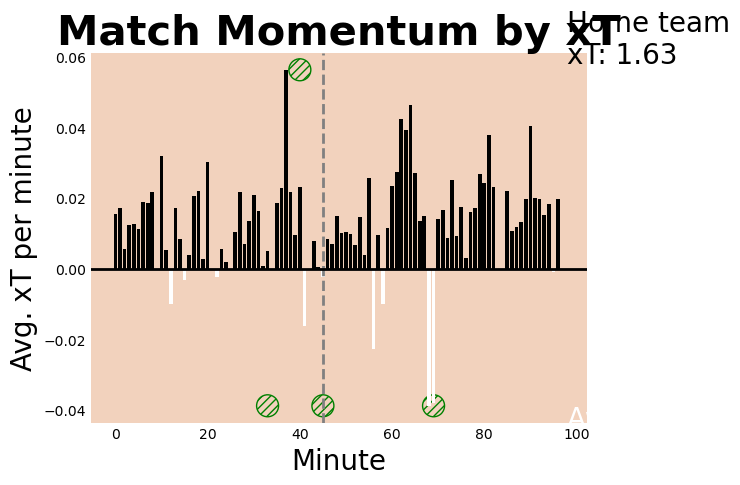

In [123]:
Momentumdf = df
# multiplying the away teams xT values with -1 so that I can plot them in the opposite of home teams
Momentumdf.loc[Momentumdf['teamId'] == ateamID, 'start_zone_value_xT'] *= -1
# taking average xT per minute
Momentumdf = Momentumdf.groupby('minute')['start_zone_value_xT'].mean()
Momentumdf = Momentumdf.reset_index()
Momentumdf.columns = ['minute', 'average_xT']
Momentumdf['average_xT'].fillna(0, inplace=True)

def plot_Momentum(ax):
  # Set colors based on positive or negative values
  colors = [hcol if x > 0 else acol for x in Momentumdf['average_xT']]

  # making a list of munutes when goals are scored
  hgoal_list = homedf[(homedf['type'] == 'Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
  agoal_list = awaydf[(awaydf['type'] == 'Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
  hog_list = homedf[(homedf['type'] == 'Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
  aog_list = awaydf[(awaydf['type'] == 'Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()

  # plotting scatters when goals are scored
  highest_xT = Momentumdf['average_xT'].max()
  lowest_xT = Momentumdf['average_xT'].min()
  highest_minute = Momentumdf['minute'].max()
  hscatter_y = [highest_xT]*len(hgoal_list)
  ascatter_y = [lowest_xT]*len(agoal_list)
  hogscatter_y = [highest_xT]*len(aog_list)
  aogscatter_y = [lowest_xT]*len(hog_list)

  ax.scatter(hgoal_list, hscatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
  ax.scatter(agoal_list, ascatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
  ax.scatter(hog_list, aogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')
  ax.scatter(aog_list, hogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')

  # Creating the bar plot
  ax.bar(Momentumdf['minute'], Momentumdf['average_xT'], color=colors)
  ax.axvline(45, color='gray', linewidth=2, linestyle='dashed')
  ax.set_facecolor(bg_color)
  # Hide spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  # Hide ticks
  ax.tick_params(axis='both', which='both', length=0)
  ax.tick_params(axis='x', colors=line_color)
  ax.tick_params(axis='y', colors=line_color)
  # Add labels and title
  ax.set_xlabel('Minute', color=line_color, fontsize=20)
  ax.set_ylabel('Avg. xT per minute', color=line_color, fontsize=20)
  ax.axhline(y=0, color=line_color, alpha=1, linewidth=2)

  ax.text(highest_minute+1,highest_xT, f"Home team\nxT: {hxT}", color=hcol, fontsize=20, va='bottom', ha='left')
  ax.text(highest_minute+1,lowest_xT,  f"Away team\nxT: {axT}", color=acol, fontsize=20, va='top', ha='left')

  ax.set_title('Match Momentum by xT', color=line_color, fontsize=30, fontweight='bold')

fig,ax=plt.subplots()
plot_Momentum(ax)

# Important note: If you run this code first time, everything will be correctly shown in the plot, but running the code second time creates a problem. As I am multiplying with -1 as I shown before, while running the code
#                 for second time all those negative values again gets multiplied by -1, so becomes positive value. Then running the code 3rd time becomes correct again, so in this way all the odd number of times runnig this code
#                 works.

In [124]:
# Here I have calculated a lot of stats, all of them I couldn't show in the viz because of lack of spaces, but I kept those in the code
#Possession%
hpossdf = df[(df['teamId']==hteamID) & (df['type']=='Pass')]
apossdf = df[(df['teamId']==ateamID) & (df['type']=='Pass')]
hposs = round((len(hpossdf)/(len(hpossdf)+len(apossdf)))*100,2)
aposs = round((len(apossdf)/(len(hpossdf)+len(apossdf)))*100,2)
#Field Tilt%
hftdf = df[(df['teamId']==hteamID) & (df['isTouch']==1) & (df['x']>=70)]
aftdf = df[(df['teamId']==ateamID) & (df['isTouch']==1) & (df['x']>=70)]
hft = round((len(hftdf)/(len(hftdf)+len(aftdf)))*100,2)
aft = round((len(aftdf)/(len(hftdf)+len(aftdf)))*100,2)
#Total Passes
htotalPass = len(df[(df['teamId']==hteamID) & (df['type']=='Pass')])
atotalPass = len(df[(df['teamId']==ateamID) & (df['type']=='Pass')])
#Accurate Pass
hAccPass = len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
aAccPass = len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
#LongBall
hLongB = len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aLongB = len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Accurate LongBall
hAccLongB = len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aAccLongB = len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Crosses
hCrss= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
aCrss= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
#Accurate Crosses
hAccCrss= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
aAccCrss= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
#Freekick
hfk= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
afk= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
#Corner
hCor= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
aCor= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
#ThrowIn
htins= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
atins= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
#GoalKicks
hglkk= len(df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
aglkk= len(df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
#Dribbling
htotalDrb = len(df[(df['teamId']==hteamID) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
atotalDrb = len(df[(df['teamId']==ateamID) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
#Accurate TakeOn
hAccDrb = len(df[(df['teamId']==hteamID) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
aAccDrb = len(df[(df['teamId']==ateamID) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
#GoalKick Length
home_goalkick = df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
away_goalkick = df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
import ast
# Convert 'qualifiers' column from string to list of dictionaries
home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
away_goalkick['qualifiers'] = away_goalkick['qualifiers'].apply(ast.literal_eval)
# Function to extract value of 'Length'
def extract_length(qualifiers):
    for item in qualifiers:
        if 'displayName' in item['type'] and item['type']['displayName'] == 'Length':
            return float(item['value'])
    return None
# Apply the function to the 'qualifiers' column
home_goalkick['length'] = home_goalkick['qualifiers'].apply(extract_length).astype(float)
away_goalkick['length'] = away_goalkick['qualifiers'].apply(extract_length).astype(float)
hglkl = round(home_goalkick['length'].mean(),2)
aglkl = round(away_goalkick['length'].mean(),2)
     

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1194364961.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1194364961.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_goalkick['qualifiers'] = away_goalkick['qualifiers'].apply(ast.literal_eval)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1194364961.py:62: SettingWit

In [125]:
#Tackles
htkl = len(df[(df['teamId']==hteamID) & (df['type']=='Tackle')])
atkl = len(df[(df['teamId']==ateamID) & (df['type']=='Tackle')])
#Tackles Won
htklw = len(df[(df['teamId']==hteamID) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
atklw = len(df[(df['teamId']==ateamID) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
#Interceptions
hintc= len(df[(df['teamId']==hteamID) & (df['type']=='Interception')])
aintc= len(df[(df['teamId']==ateamID) & (df['type']=='Interception')])
#Clearances
hclr= len(df[(df['teamId']==hteamID) & (df['type']=='Clearance')])
aclr= len(df[(df['teamId']==ateamID) & (df['type']=='Clearance')])
#Aerials
harl= len(df[(df['teamId']==hteamID) & (df['type']=='Aerial')])
aarl= len(df[(df['teamId']==ateamID) & (df['type']=='Aerial')])
#Aerials Wins
harlw= len(df[(df['teamId']==hteamID) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
aarlw= len(df[(df['teamId']==ateamID) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
#BallRecovery
hblrc= len(df[(df['teamId']==hteamID) & (df['type']=='BallRecovery')])
ablrc= len(df[(df['teamId']==ateamID) & (df['type']=='BallRecovery')])
#BlockedPass
hblkp= len(df[(df['teamId']==hteamID) & (df['type']=='BlockedPass')])
ablkp= len(df[(df['teamId']==ateamID) & (df['type']=='BlockedPass')])
#OffsideGiven
hofs= len(df[(df['teamId']==hteamID) & (df['type']=='OffsideGiven')])
aofs= len(df[(df['teamId']==ateamID) & (df['type']=='OffsideGiven')])
#Fouls
hfoul= len(df[(df['teamId']==hteamID) & (df['type']=='Foul')])
afoul= len(df[(df['teamId']==ateamID) & (df['type']=='Foul')])

In [126]:
def plotting_match_stats(ax):
  pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
  pitch.draw(ax=ax)

  # plotting the headline box
  head_y = [62,68,68,62]
  head_x = [0,0,105,105]
  ax.fill(head_x, head_y, 'orange')
  ax.text(52.5,64.5, "Match Stats", ha='center', va='center', color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

  # Stats bar diagram
  stats_title = [58, 58-(1*6), 58-(2*6), 58-(3*6), 58-(4*6), 58-(5*6), 58-(6*6), 58-(7*6), 58-(8*6), 58-(9*6), 58-(10*6)] # y co-ordinate values of the bars
  stats_home = [hposs, hft, htotalPass, hLongB, hCor, hglkl, htkl, hintc, hclr, harl, hblrc]
  stats_away = [aposs, aft, atotalPass, aLongB, aCor, aglkl, atkl, aintc, aclr, aarl, ablrc]

  stats_normalized_home = [-(hposs/(hposs+aposs))*45, -(hft/(hft+aft))*45, -(htotalPass/(htotalPass+atotalPass))*45,
                                        -(hLongB/(hLongB+aLongB))*45, -(hCor/(hCor+aCor))*45, -(hglkl/(hglkl+aglkl))*45, -(htkl/(htkl+atkl))*45,       # put a (-) sign before each value so that the
                                        -(hintc/(hintc+aintc))*45, -(hclr/(hclr+aclr))*45, -(harl/(harl+aarl))*45, -(hblrc/(hblrc+ablrc))*45]          # home stats bar shows in the opposite of away
  stats_normalized_away = [(aposs/(hposs+aposs))*45, (aft/(hft+aft))*45, (atotalPass/(htotalPass+atotalPass))*45,
                                        (aLongB/(hLongB+aLongB))*45, (aCor/(hCor+aCor))*45, (aglkl/(hglkl+aglkl))*45, (atkl/(htkl+atkl))*45,
                                        (aintc/(hintc+aintc))*45, (aclr/(hclr+aclr))*45, (aarl/(harl+aarl))*45, (ablrc/(hblrc+ablrc))*45]

  start_x = 52.5
  ax.barh(stats_title, stats_normalized_home, height=4, color=hcol, left=start_x)
  ax.barh(stats_title, stats_normalized_away, height=4, left=start_x, color=acol)
  # Turn off axis-related elements
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
  ax.set_xticks([])
  ax.set_yticks([])

  # Plotting the texts
  ax.text(52.5, 58, "Possession", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(1*6), "Field Tilt", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(2*6), "Passes (Acc.)", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(3*6), "LongBalls (Acc.)", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(4*6), "Corners", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(5*6), "Goalkick len.", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(6*6), "Tackles (Wins)", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(7*6), "Interceptions", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(8*6), "Clearence", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(9*6), "Aerials (Wins)", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)
  ax.text(52.5, 58-(10*6), "Ball Recoveries", color=line_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff)

  ax.text(7.5, 58, f"{int(hposs)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(1*6), f"{int(hft)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(2*6), f"{htotalPass}({hAccPass})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(3*6), f"{hLongB}({hAccLongB})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(4*6), f"{hCor}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(5*6), f"{hglkl}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(6*6), f"{htkl}({htklw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(7*6), f"{hintc}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(8*6), f"{hclr}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(9*6), f"{harl}({harlw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
  ax.text(7.5, 58-(10*6), f"{hblrc}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')

  ax.text(97.5, 58, f"{int(aposs)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(1*6), f"{int(aft)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(2*6), f"{atotalPass}({aAccPass})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(3*6), f"{aLongB}({aAccLongB})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(4*6), f"{aCor}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(5*6), f"{aglkl}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(6*6), f"{atkl}({atklw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(7*6), f"{aintc}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(8*6), f"{aclr}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(9*6), f"{aarl}({aarlw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
  ax.text(97.5, 58-(10*6), f"{ablrc}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
     

In [127]:
def HighTO(ax):
  pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
  pitch.draw(ax=ax)
  ax.set_ylim(-0.5,68.5)
  ax.set_xlim(-0.5,105.5)

  # filtering the high turnovers (winning the possession inside the 40m radius from opponent goal)
  home_TO = df[(df['teamId']==hteamID) & ((df['type']=='BallRecovery') | (df['type']=='Interception')) & (df['x']>=70)]
  away_TO = df[(df['teamId']==ateamID) & ((df['type']=='BallRecovery') | (df['type']=='Interception')) & (df['x']>=70)]

  home_TO['distance'] = ((home_TO['x'] - 105)**2 + (home_TO['y'] - 34)**2)**0.5
  home_TO = home_TO[home_TO['distance']<=40]
  away_TO['distance'] = ((away_TO['x'] - 105)**2 + (away_TO['y'] - 34)**2)**0.5
  away_TO = away_TO[away_TO['distance']<=40]

  hto_count = len(home_TO)
  ato_count = len(away_TO)

  # scattering those
  ax.scatter((105-home_TO.x), (68-home_TO.y), s=250, c=hcol, edgecolor=line_color, marker='o', linewidth=2)
  ax.scatter((away_TO.x), (away_TO.y), s=250, c=acol, edgecolor=line_color, marker='o', linewidth=2)

  # Plotting the half circle
  left_circle = plt.Circle((0,34), 40, color=hcol, fill=True, alpha=0.25, linestyle='dashed')
  ax.add_artist(left_circle)
  right_circle = plt.Circle((105,34), 40, color=acol, fill=True, alpha=0.25, linestyle='dashed')
  ax.add_artist(right_circle)
  # Set the aspect ratio to be equal
  ax.set_aspect('equal', adjustable='box')
  # Headlines and other texts
  ax.text(0, 70, f"Home team\nHigh Turnover: {hto_count}", color=hcol, size=25, ha='left', fontweight='bold')
  ax.text(105, 70, f"Away team\nHigh Turnover: {ato_count}", color=acol, size=25, ha='right', fontweight='bold')
     

In [128]:
def Crosses(ax):
  pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
  pitch.draw(ax=ax)
  ax.set_ylim(-0.5,68.5)
  ax.set_xlim(-0.5,105.5)

  home_cross = df[(df['teamId']==hteamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]
  away_cross = df[(df['teamId']==ateamID) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]

  hsuc = 0
  hunsuc = 0
  asuc = 0
  aunsuc = 0

  # iterating through each pass and coloring according to successful or not
  for index, row in home_cross.iterrows():
    if row['outcomeType'] == 'Successful':
      arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=15, color='green', linewidth=1.5, alpha=1)      # the x and y points are substracted from pitch length and width
      ax.add_patch(arrow)                                                                                                                                                             # to show both home and away passes in the same pitch
      hsuc += 1
    else:
      arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=10, color='red', linewidth=1.5, alpha=.65)
      ax.add_patch(arrow)
      hunsuc += 1

  for index, row in away_cross.iterrows():
    if row['outcomeType'] == 'Successful':
      arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color='green', linewidth=1.5, alpha=1)
      ax.add_patch(arrow)
      asuc += 1
    else:
      arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=10, color='red', linewidth=1.5, alpha=.65)
      ax.add_patch(arrow)
      aunsuc += 1

  # Headlines and other texts
  home_left = len(home_cross[home_cross['y']>=34])
  home_right = len(home_cross[home_cross['y']<34])
  away_left = len(away_cross[away_cross['y']>=34])
  away_right = len(away_cross[away_cross['y']<34])

  ax.text(51, 2, f"Crosses from\nLeftwing: {home_left}", color=hcol, fontsize=15, va='bottom', ha='right')
  ax.text(51, 66, f"Crosses from\nRightwing: {home_right}", color=hcol, fontsize=15, va='top', ha='right')
  ax.text(54, 66, f"Crosses from\nLeftwing: {away_left}", color=acol, fontsize=15, va='top', ha='left')
  ax.text(54, 2, f"Crosses from\nRightwing: {away_right}", color=acol, fontsize=15, va='bottom', ha='left')

  ax.text(0,-2, f"Successful: {hsuc}", color='green', fontsize=20, ha='left', va='top')
  ax.text(0,-5.5, f"Unsuccessful: {hunsuc}", color='red', fontsize=20, ha='left', va='top')
  ax.text(105,-2, f"Successful: {asuc}", color='green', fontsize=20, ha='right', va='top')
  ax.text(105,-5.5, f"Unsuccessful: {aunsuc}", color='red', fontsize=20, ha='right', va='top')

  ax.text(0, 70, f"Home team Crosses", color=hcol, size=25, ha='left', fontweight='bold')
  ax.text(105, 70, f"Away team Crosses", color=acol, size=25, ha='right', fontweight='bold')

  ax.text(52.5, -20, "________________________________________________________________________________________________________________________________________________________________________________________________________________________________",
          color=line_color, fontsize=20, va='center', ha='center')
     

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1140654074.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1140654074.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_7005/1140654074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

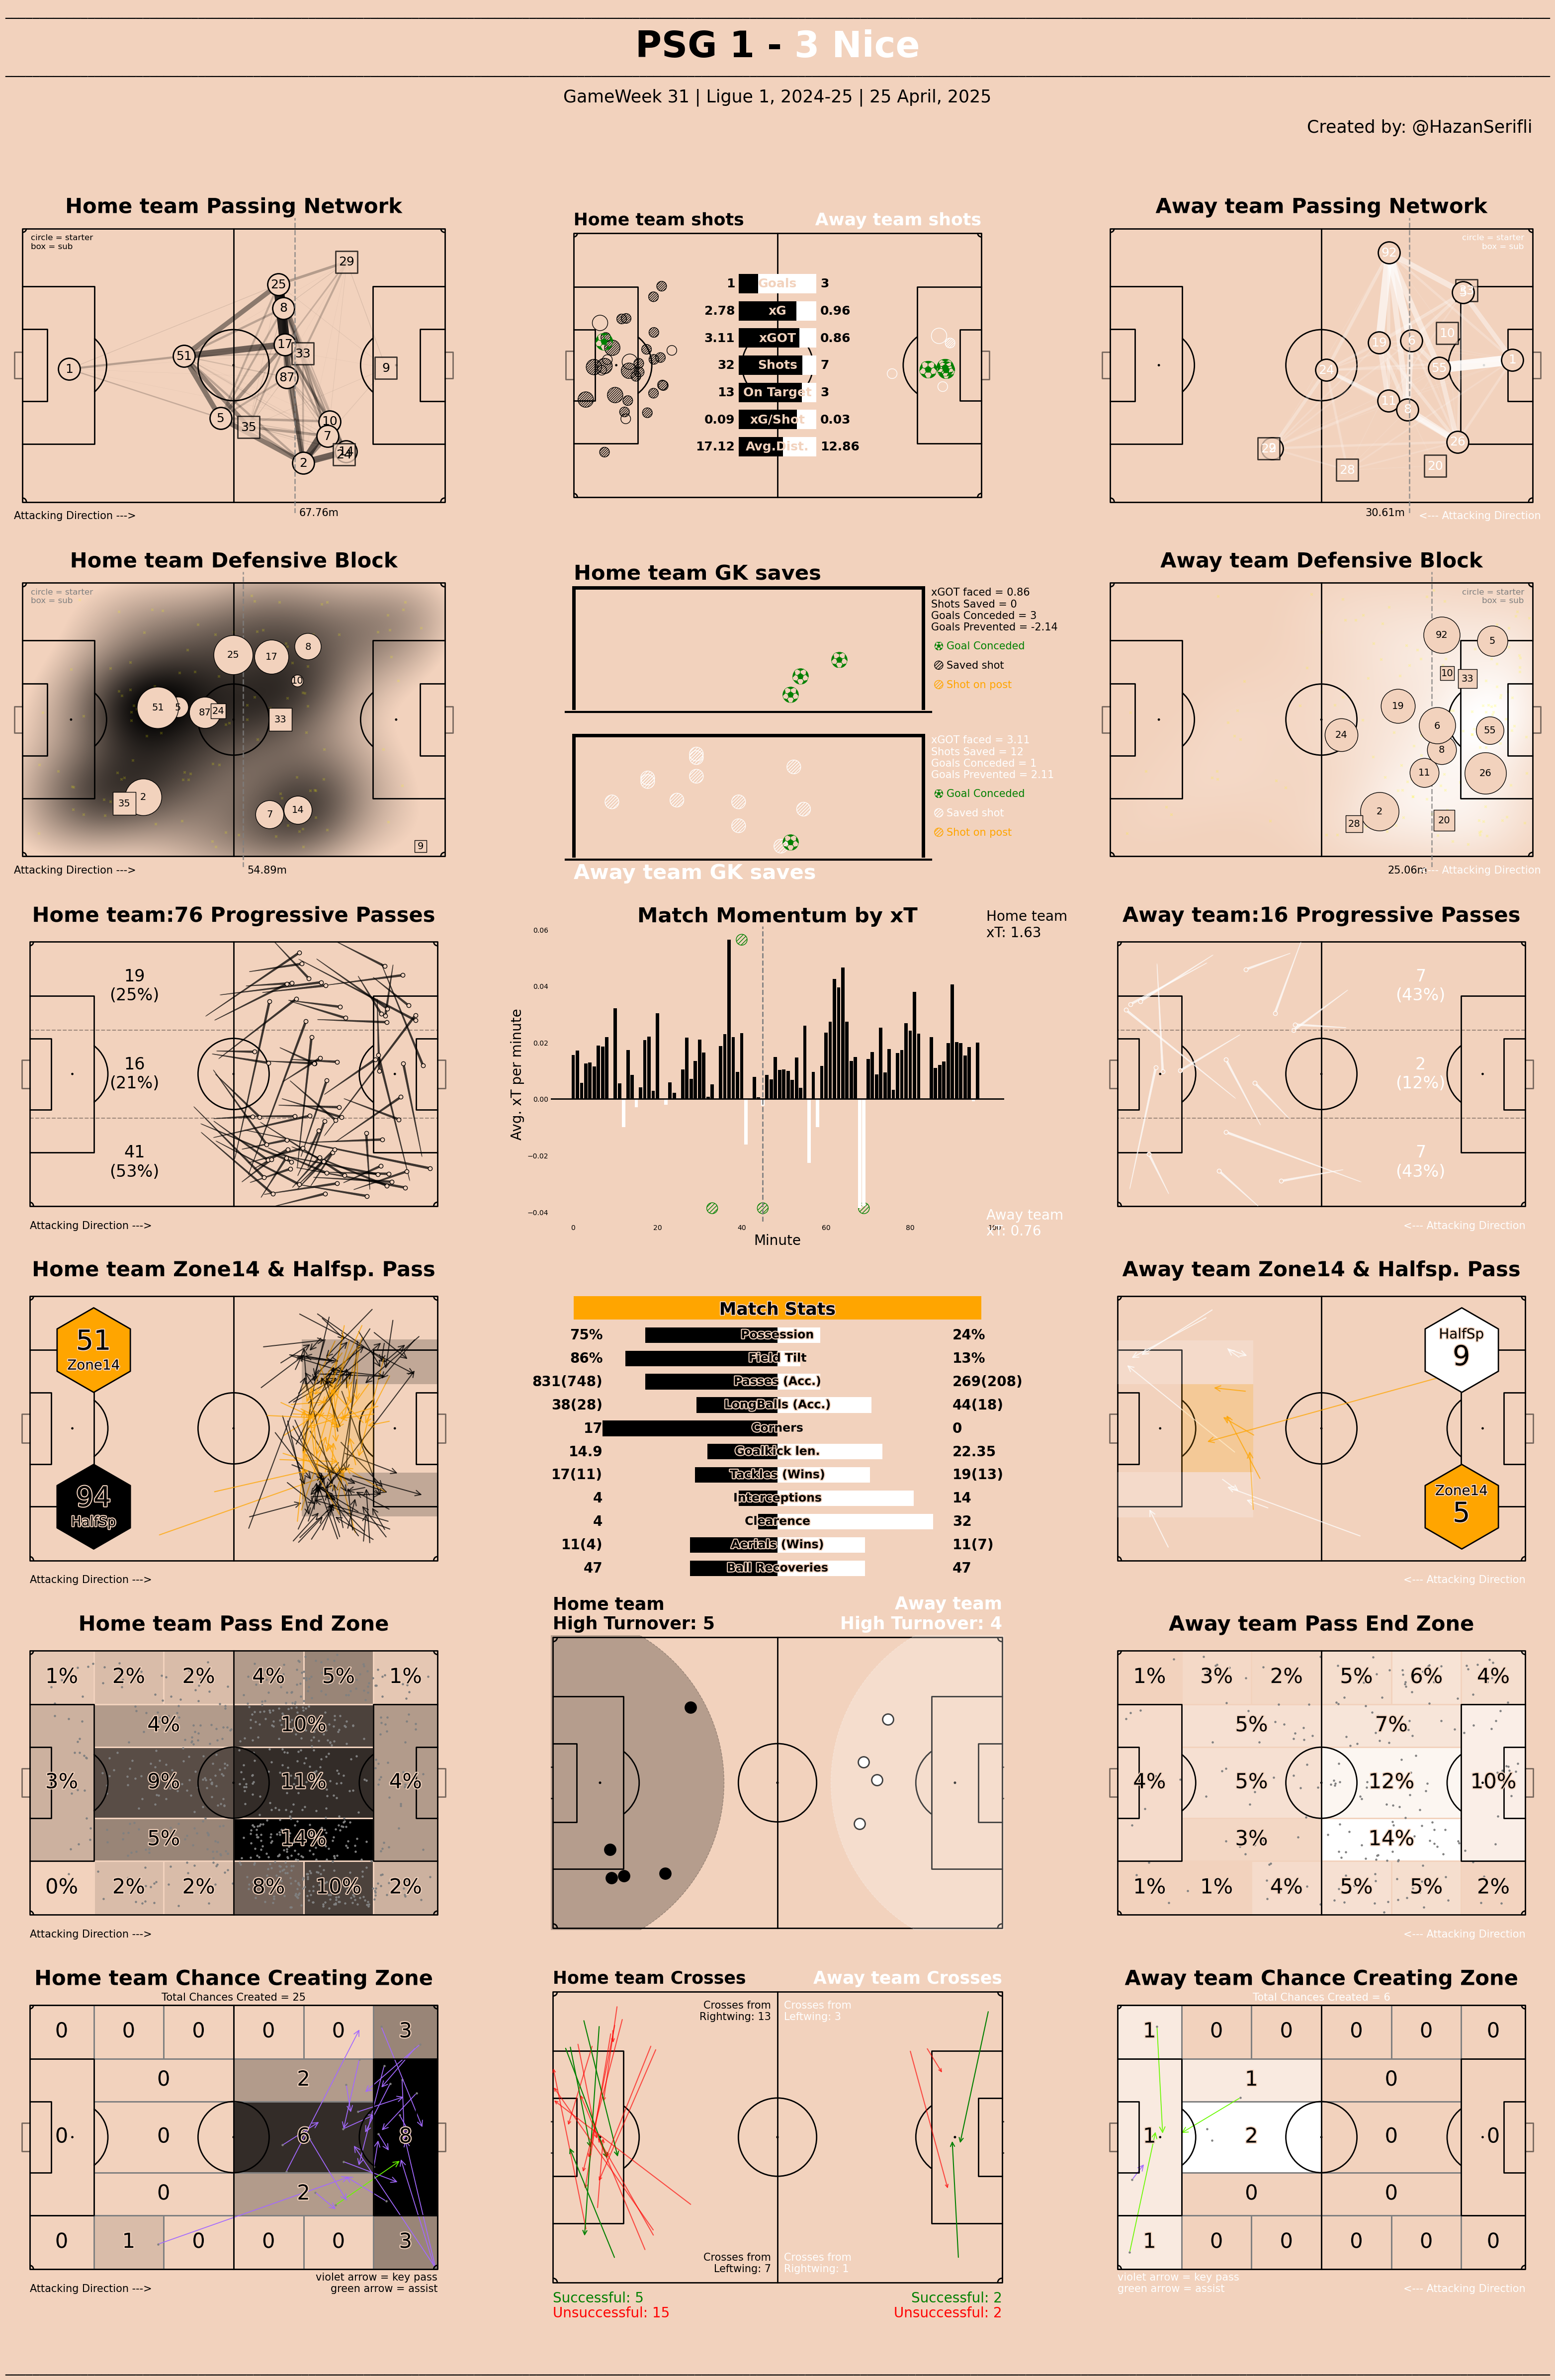

In [129]:

# Making a big plot which has 18 subplots in 6 rows and 3 columns
fig, axs = plt.subplots(6,3, figsize=(40,54), facecolor=bg_color)
# PassNetwork
pass_network_visualization(axs[0,0], home_passes_between_df, home_average_locs_and_count_df, hcol, home_team_id)
plot_shotmap(axs[0,1]) # shotmap
pass_network_visualization(axs[0,2], away_passes_between_df, away_average_locs_and_count_df, acol, away_team_id)
# Defensive Block
defensive_block(axs[1,0], defensive_home_average_locs_and_count_df, hteamName, hteamID, hcol)
plot_goalPost(axs[1,1]) # goalpost
defensive_block(axs[1,2], defensive_away_average_locs_and_count_df, ateamName, ateamID, acol)
# Progressive Passes
draw_progressive_pass_map(axs[2,0], dfhpp, hteamName, hcol)
plot_Momentum(axs[2,1]) # match momentum
draw_progressive_pass_map(axs[2,2], dfapp, ateamName, acol)
# Danger Zone Passes
draw_pass_map(axs[3,0], dfhp, hteamName, hcol)
plotting_match_stats(axs[3,1]) # match stats
draw_pass_map(axs[3,2], dfap, ateamName, acol)
# Pass End Zone
Pass_end_zone(axs[4,0], hdfPEZ, hteamName, pearl_earring_cmaph, hcol)
HighTO(axs[4,1]) # high turnover
Pass_end_zone(axs[4,2], adfPEZ, ateamName, pearl_earring_cmapa, acol)
# Chance Creating Zone
Chance_creating_zone(axs[5,0], dfchch, hteamName, pearl_earring_cmaph, hcol)
Crosses(axs[5,1]) # crosses
Chance_creating_zone(axs[5,2], dfchca, ateamName, pearl_earring_cmapa, acol)